## EDA Checking Data

In [7]:
import pandas as pd
import numpy as np
import pickle, gc
from matplotlib import pyplot as plt

In [2]:
train_data = pd.read_feather('/home/vincent0110/test/Kaggle_Amex/data/train_data.ftr')
test_data = pd.read_feather('/home/vincent0110/test/Kaggle_Amex/data/test_data.ftr')

In [3]:
train_data.target.isna().any().any(), train_data.customer_ID.duplicated().any()

(False, True)

In [4]:
print('Train statement dates: ', train_data.S_2.min(), train_data.S_2.max(), train_data.S_2.isna().any())
print('Test statement dates: ',  test_data.S_2.min(), test_data.S_2.max(), test_data.S_2.isna().any())

Train statement dates:  2017-03-01 00:00:00 2018-03-31 00:00:00 False
Test statement dates:  2018-04-01 00:00:00 2019-10-31 00:00:00 False


In [5]:
train_data.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

## Statement Per Customer in Train and Test

#### Analysis: 80% of the customers recieve 13 statements

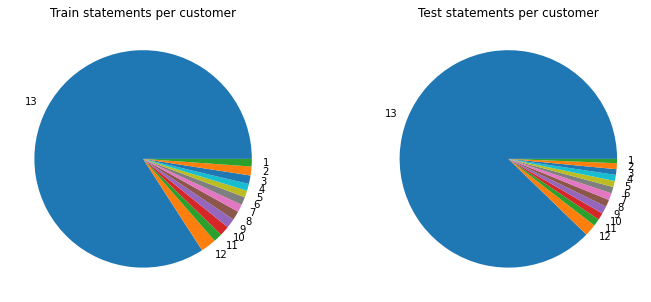

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train_data.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
test_sc = test_data.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
ax2.pie(test_sc, labels=test_sc.index)
ax2.set_title(test_sc.name)
plt.show()


## Date of Last Statements

#### Analysis: Test data seems to have been split for the public and private leaderboards

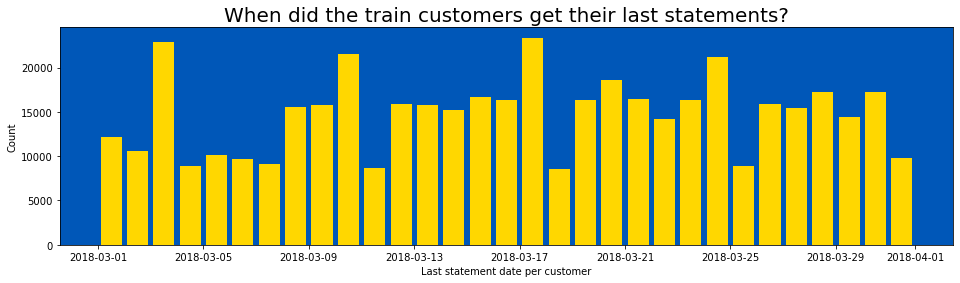

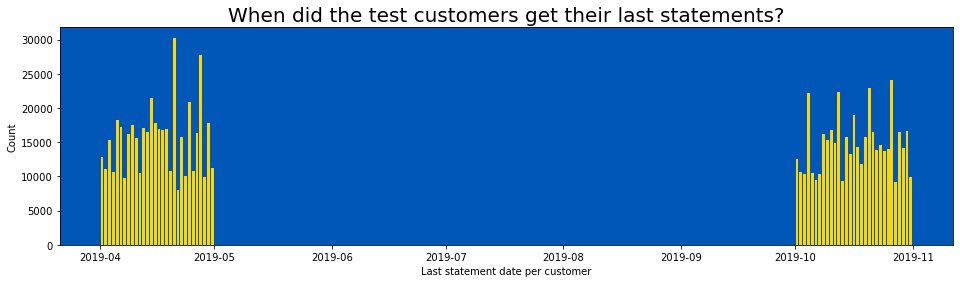

In [11]:
temp = train_data.S_2.groupby(train_data.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test_data.S_2.groupby(test_data.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

## Days between first and last statement

#### Analysis: Average is about a year, meaning customers normally get one statement per month 

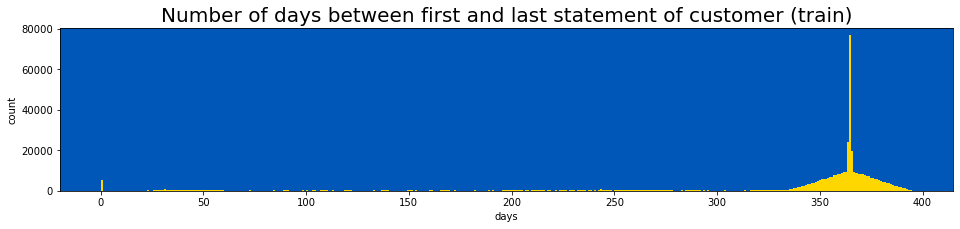

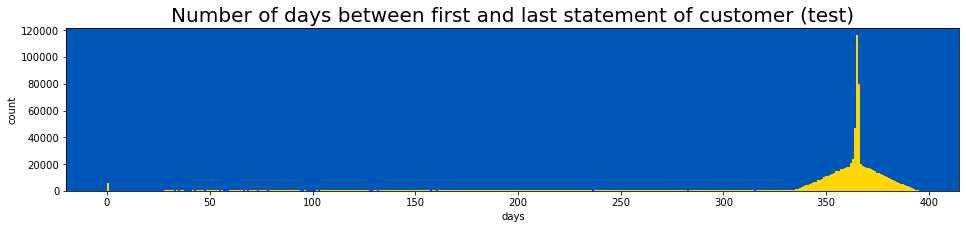

In [12]:
temp = train_data.S_2.groupby(train_data.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()

temp = test_data.S_2.groupby(test_data.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (test)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

## NULL Values in different Categories and datasets

#### Analysis: B_29 is not available for 90% of the training sets but availbe in private set

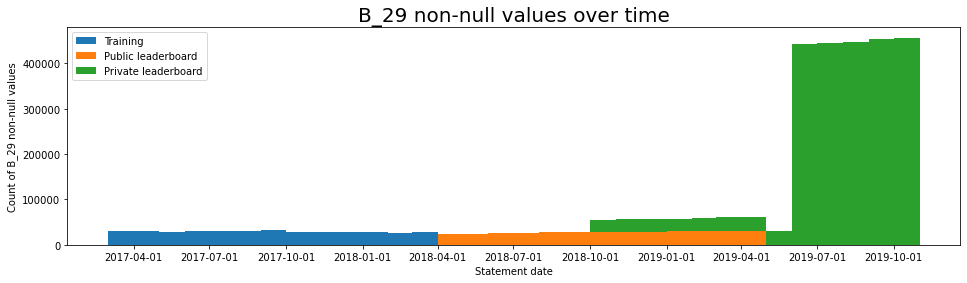

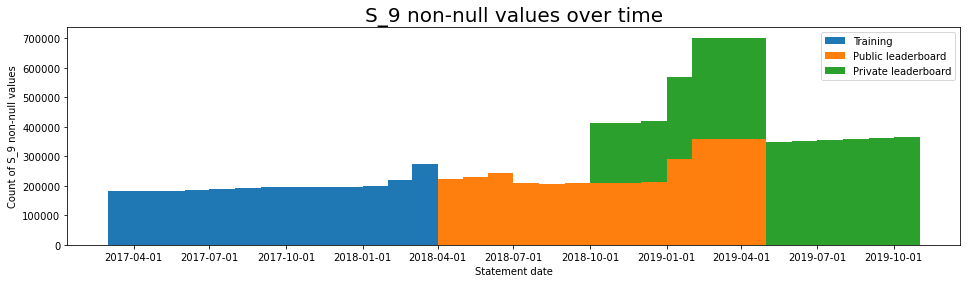

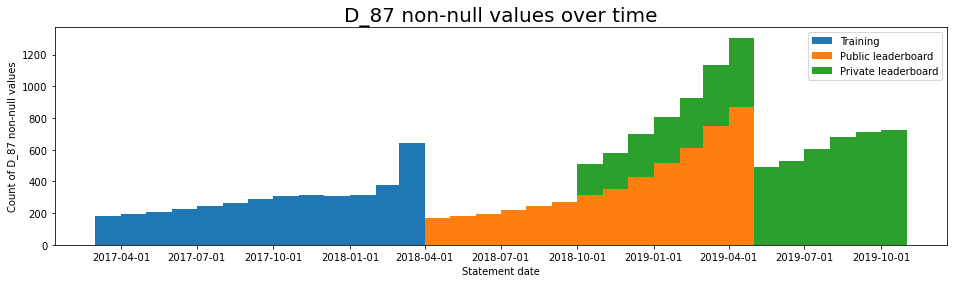

In [15]:

temp = pd.concat([train_data[['customer_ID', 'S_2']], test_data[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)
temp['last_month'] = temp.groupby('customer_ID').S_2.max().dt.month
last_month = temp['last_month'].values
del temp
for f in [ 'B_29', 'S_9','D_87']:#, 'D_88', 'R_26', 'R_27', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42']:
    temp = pd.concat([train_data[[f, 'S_2']], test_data[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna() 

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
             label=['Training', 'Public leaderboard', 'Private leaderboard'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()